## Which is higher: 4 out of 10, or 300 out of 1000?

Obviously 0.4 is greater than 0.3, but if you are evaluating two basketball players: the first one got 300 2-pointer goals out of 1000 attempts, and the second one is pretty new and he got 4 2-pointer goals out of 10. 

It's difficult to measure the performance of these two players, because the first player has a proportion of goals but it's not a lot of evidence. Therefore, we will use empirical Bayes estimation to estimate their 2-pointer-goal average.

Empirical Bayes estimation, where a beta distribution fit on all observations is then used to improve each individually.

What's great about this method is that as long as we have a lot of examples, we don't need to bring in prior expectations.

This is notebook we will use the [nba-players-stats dataset from kaggle](https://www.kaggle.com/drgilermo/nba-players-stats) to estimate the prior expectation.

## Dataset Setup

In [1]:
import os
import math
import pandas as pd
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

In [2]:
project_dir = '/mnt/data-ubuntu/Projects/statistics_python3'

In [3]:
df_nba = pd.read_csv(project_dir + '/data/nba-players-stats/Seasons_Stats.csv')

In [4]:
df_nba.columns

Index(['Unnamed: 0', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'blanl', 'OWS', 'DWS', 'WS', 'WS/48', 'blank2',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

In [5]:
# We will select all players in position PG and there 
df_pg = df_nba \
    .loc[:, ['Year', 'Player', 'Pos', '2P', '2PA']] \
    .where(df_nba.loc[:,'Pos']=='PG') \
    .dropna()
# Group up by year and player
df_pg = df_pg.groupby(['Year', 'Player', 'Pos']).sum().reset_index()
# Create 2P%: Two Point Field Goal Percentage
df_pg['2P%'] = df_pg.loc[:, '2P'] / df_pg.loc[:, '2PA']
df_pg.loc[:,'2P%'].fillna(0, inplace = True)
df_pg

,Year,Player,Pos,2P,2PA,2P%
0,1950.0,Al Cervi*,PG,143.0,431.0,0.331787
1,1950.0,Bob Davies*,PG,317.0,887.0,0.357384
2,1950.0,Dick McGuire*,PG,190.0,563.0,0.337478
3,1950.0,Fred Scolari,PG,312.0,910.0,0.342857
4,1950.0,George Senesky,PG,227.0,709.0,0.320169
...,...,...,...,...,...,...
3784,2017.0,Tyler Johnson,PG,264.0,574.0,0.459930
3785,2017.0,Tyler Ulis,PG,163.0,358.0,0.455307
3786,2017.0,Tyus Jones,PG,49.0,108.0,0.453704
3787,2017.0,Wade Baldwin,PG,33.0,93.0,0.354839


In [6]:
# Let's see who is the best and who is the worst.
df_pg.sort_values('2P%',ascending = False).head()

,Year,Player,Pos,2P,2PA,2P%
1875,1996.0,Randy Woods,PG,1.0,1.0,1.0
3368,2013.0,Julyan Stone,PG,2.0,2.0,1.0
435,1971.0,Milt Williams,PG,1.0,1.0,1.0
1548,1992.0,Myron Brown,PG,3.0,3.0,1.0
2302,2001.0,Jason Hart,PG,1.0,1.0,1.0


In [7]:
df_pg.sort_values('2P%').head()

,Year,Player,Pos,2P,2PA,2P%
2884,2007.0,Will Conroy,PG,0.0,3.0,0.0
2672,2005.0,Maurice Baker,PG,0.0,2.0,0.0
730,1979.0,Del Beshore,PG,0.0,0.0,0.0
2701,2005.0,Yuta Tabuse,PG,0.0,5.0,0.0
2706,2006.0,Alvin Williams,PG,0.0,1.0,0.0


Apparently, the 2-pointer-goal average is a ineffectual measurement.

In [8]:
# Exclude 0 and 1 to fit a beta distribution later
df_b = df_pg[(df_pg.loc[:,'2P%']<1) & (df_pg.loc[:,'2P%']>0)]
df_b['bin'] = pd.cut(df_b.loc[:,'2P%'], bins=np.linspace(0, 1, 50), include_lowest=True)
df_b

/home/rick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Year,Player,Pos,2P,2PA,2P%,bin
0,1950.0,Al Cervi*,PG,143.0,431.0,0.331787,"(0.327, 0.347]"
1,1950.0,Bob Davies*,PG,317.0,887.0,0.357384,"(0.347, 0.367]"
2,1950.0,Dick McGuire*,PG,190.0,563.0,0.337478,"(0.327, 0.347]"
3,1950.0,Fred Scolari,PG,312.0,910.0,0.342857,"(0.327, 0.347]"
4,1950.0,George Senesky,PG,227.0,709.0,0.320169,"(0.306, 0.327]"
...,...,...,...,...,...,...,...
3784,2017.0,Tyler Johnson,PG,264.0,574.0,0.459930,"(0.449, 0.469]"
3785,2017.0,Tyler Ulis,PG,163.0,358.0,0.455307,"(0.449, 0.469]"
3786,2017.0,Tyus Jones,PG,49.0,108.0,0.453704,"(0.449, 0.469]"
3787,2017.0,Wade Baldwin,PG,33.0,93.0,0.354839,"(0.347, 0.367]"


## Estimate a prior from the data

### Draw a graph of the distribution of 2P averages across players.

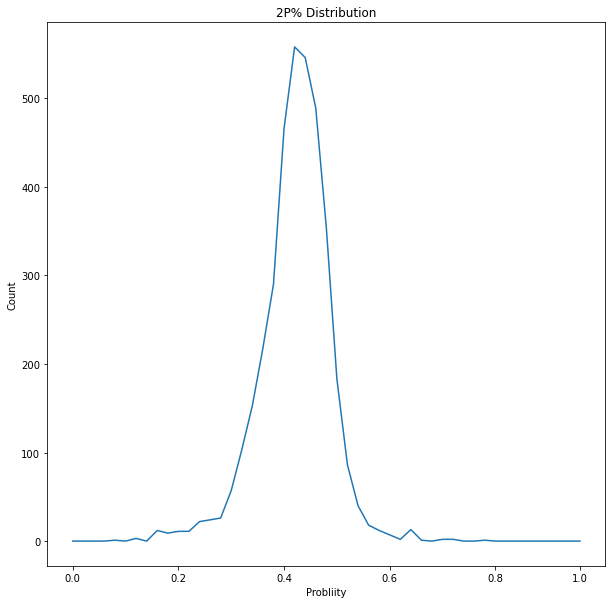

In [9]:

fig, ax = plt.subplots(figsize = (10, 10))
df_temp = df_b \
    .groupby('bin') \
    .count() \
    .loc[:, 'Player']

df_temp.plot(kind = 'line',
          figsize = (10, 10),
          ax = ax,
          title = '2P% Distribution')

# positions of each tick, relative to the indices of the x-values
pos = list(range(0, df_temp.size, 10)) + [df_temp.size-1]
ax.set_xticks(pos)

# labels
ax.set_xticklabels([round(n,2) for n in np.linspace(0, 1, len(pos))])
plt.ylabel('Count')
plt.xlabel('Probliity')
plt.show()

### Calculate the a and b

We need to calculate the a and b for our bete(a, b) distribution.

In [10]:
df_b.loc[:,'2P%']

0       0.331787
1       0.357384
2       0.337478
3       0.342857
4       0.320169
          ...   
3784    0.459930
3785    0.455307
3786    0.453704
3787    0.354839
3788    0.422018
Name: 2P%, Length: 3720, dtype: float64

In [11]:
beta_fit = beta.fit(data = df_b.loc[:,'2P%'], floc=0, fscale=1)
a = round(beta_fit[0], 2)
b = round(beta_fit[1], 2)
print(f'a: {a},b: {b}')

a: 23.05,b: 29.35


### Calculate each estimate based on beta distribution



In [12]:
df_pg.sort_values('2P%').head()

,Year,Player,Pos,2P,2PA,2P%
2884,2007.0,Will Conroy,PG,0.0,3.0,0.0
2672,2005.0,Maurice Baker,PG,0.0,2.0,0.0
730,1979.0,Del Beshore,PG,0.0,0.0,0.0
2701,2005.0,Yuta Tabuse,PG,0.0,5.0,0.0
2706,2006.0,Alvin Williams,PG,0.0,1.0,0.0


Now we can calculate individual 2P% based on beta distribution(prior). For example the player Will Conroy, his 2P% is 23.05/(23.05+29.35+3) = 0.416. With the updated 2P%, we can compare him with other players.

In [13]:
# Calculate individual estimate

df_pg['2P%_estimate'] = df_pg.apply(lambda x: (x['2P']+a)/(a+b+x['2PA']), axis = 1)
df_pg

,Year,Player,Pos,2P,2PA,2P%,2P%_estimate
0,1950.0,Al Cervi*,PG,143.0,431.0,0.331787,0.343504
1,1950.0,Bob Davies*,PG,317.0,887.0,0.357384,0.361986
2,1950.0,Dick McGuire*,PG,190.0,563.0,0.337478,0.346198
3,1950.0,Fred Scolari,PG,312.0,910.0,0.342857,0.348140
4,1950.0,George Senesky,PG,227.0,709.0,0.320169,0.328408
...,...,...,...,...,...,...,...
3784,2017.0,Tyler Johnson,PG,264.0,574.0,0.459930,0.458254
3785,2017.0,Tyler Ulis,PG,163.0,358.0,0.455307,0.453338
3786,2017.0,Tyus Jones,PG,49.0,108.0,0.453704,0.449190
3787,2017.0,Wade Baldwin,PG,33.0,93.0,0.354839,0.385488


In [14]:
# Now let's see who is the best and who is the worst
df_pg.sort_values('2P%_estimate',ascending = False).head()

,Year,Player,Pos,2P,2PA,2P%,2P%_estimate
629,1977.0,Dave Twardzik,PG,263.0,430.0,0.611628,0.592973
1246,1988.0,John Stockton*,PG,430.0,724.0,0.593923,0.583527
935,1983.0,Brad Davis,PG,348.0,585.0,0.594872,0.582131
1938,1997.0,John Stockton*,PG,340.0,579.0,0.587219,0.574992
677,1978.0,Dave Twardzik,PG,242.0,409.0,0.591687,0.574447


In [15]:
df_pg.sort_values('2P%_estimate').head()

,Year,Player,Pos,2P,2PA,2P%,2P%_estimate
10,1950.0,Walt Kirk,PG,194.0,722.0,0.268698,0.280282
130,1958.0,Brendan McCann,PG,22.0,100.0,0.220000,0.295604
34,1952.0,Red Holzman*,PG,104.0,372.0,0.279570,0.299364
66,1954.0,Bill Tosheff,PG,168.0,578.0,0.290657,0.303062
60,1953.0,Red Holzman*,PG,38.0,149.0,0.255034,0.303128


In [16]:
# Save the data set as csv file.
df_pg.to_csv(project_dir + '/data/nba-players-stats/seasons_stats_pg.csv', index = False)

Lastly, let's answer our question: Which player is better: the player with 4 goals out of 10, or the player with 300 goals out of 1000.

In [17]:
print(f'2P% _estimate for the first player is (4+a)/(10+a+b)={round((4+a)/(10+a+b),2)}')
print(f'2P% _estimate for the first player is (300+a)/(1000+a+b)={round((300+a)/(1000+a+b),2)}')

2P% _estimate for the first player is (4+a)/(10+a+b)=0.43
2P% _estimate for the first player is (300+a)/(1000+a+b)=0.31


Based on the evidence given, the player one would be our choice, but it's better to see more evidence. We will explore more methods to evaluate the performance in the following sections.